# LCCDE: A Decision-Based Ensemble Framework for Intrusion Detection in The Internet of Vehicles
This is the code for the paper entitled "**LCCDE: A Decision-Based Ensemble Framework for Intrusion Detection in The Internet of Vehicles**" accepted in 2022 IEEE Global Communications Conference (GLOBECOM).  
Authors: Li Yang (lyang339@uwo.ca), Abdallah Shami (Abdallah.Shami@uwo.ca), Gary Stevens, and Stephen de Rusett  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University, Ontario, Canada; S2E Technologies, St. Jacobs, Ontario, Canada  

If you find this repository useful in your research, please cite:  
L. Yang, A. Shami, G. Stevens, and S. DeRusett, “LCCDE: A Decision-Based Ensemble Framework for Intrusion Detection in The Internet of Vehicles," in 2022 IEEE Global Communications Conference (GLOBECOM), 2022, pp. 1-6.

## Import libraries

In [177]:
import warnings
warnings.filterwarnings("ignore")

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
#import catboost as cbt
import xgboost as xgb
import time
from river import stream
from statistics import mode

## Read the sampled CICIDS2017 dataset
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  
Due to the large size of this dataset, the sampled subsets of CICIDS2017 is used. The subsets are in the "data" folder.  
If you want to use this code on other datasets (e.g., CAN-intrusion dataset), just change the dataset name and follow the same steps. The models in this code are generic models that can be used in any intrusion detection/network traffic datasets.

In [179]:
df = pd.read_csv("./data/CICIDS2017_sample_km.csv")

In [180]:
df.Label.value_counts()

0    18225
3     3042
6     2180
1     1966
5     1255
2       96
4       36
Name: Label, dtype: int64

**Corresponding Attack Types:**  
0 BENIGN &emsp; 18225  
3 DoS        &emsp;   &emsp;   3042  
6 WebAttack    &emsp;      2180  
1 Bot        &emsp;  &emsp;      1966    
5 PortScan  &emsp;       1255  
2 BruteForce  &emsp;      96  
4 Infiltration  &emsp;       36  

## Split train set and test set

In [181]:
X = df.drop(['Label'],axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.9, test_size = 0.1, random_state = 0) #shuffle=False

## SMOTE to solve class-imbalance

In [182]:
pd.Series(y_train).value_counts()

0    16405
3     2735
6     1961
1     1765
5     1135
2       89
4       30
Name: Label, dtype: int64

In [183]:
from imblearn.over_sampling import SMOTE


smote=SMOTE(k_neighbors=1,n_jobs=-1,sampling_strategy={2:1000,4:1000})


In [184]:
#X_train, y_train = smote.fit_resample(X_train, y_train)

### difreant over sampling 

the sampling now has varaiance and is not all linerar 

In [185]:
from imblearn.over_sampling import ADASYN
asasyn = ADASYN(n_jobs=-1,sampling_strategy={2:1000,4:1000})
X_train, y_train = asasyn.fit_resample(X_train,y_train)

In [186]:
pd.Series(y_train).value_counts()

0    16405
3     2735
6     1961
1     1765
5     1135
4     1000
2      998
Name: Label, dtype: int64

## Machine Learning (ML) model training
### Training three base learners: LightGBM, XGBoost, CatBoost

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1820
           1       0.99      0.99      0.99       201
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00       307
           4       1.00      0.83      0.91         6
           5       0.99      1.00      1.00       120
           6       1.00      1.00      1.00       219

    accuracy                           1.00      2680
   macro avg       1.00      0.97      0.98      2680
weighted avg       1.00      1.00      1.00      2680

Accuracy of LightGBM: 0.9977611940298508
Precision of LightGBM: 0.9977611611601747
Recall of LightGBM: 0.9977611940298508
Average F1 of LightGBM: 0.9977429374454967
F1 of LightGBM for each type of attack: [0.99862675 0.98753117 1.         1.         0.90909091 0.99585062
 1.        ]


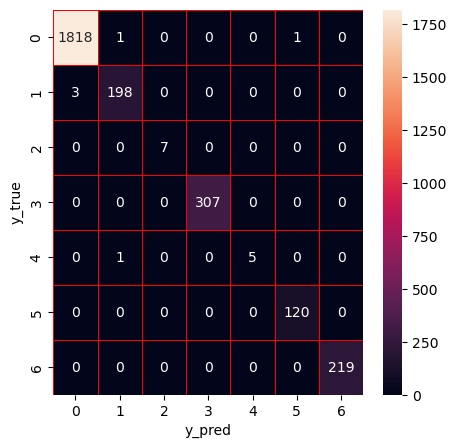

CPU times: user 18.2 s, sys: 2.77 s, total: 21 s
Wall time: 3.18 s


In [187]:
%%time
# Train the LightGBM algorithm
import lightgbm as lgb
lg = lgb.LGBMClassifier()
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy of LightGBM: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of LightGBM: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of LightGBM: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of LightGBM: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of LightGBM for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
lg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1820
           1       0.99      0.99      0.99       201
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00       307
           4       1.00      0.83      0.91         6
           5       0.99      1.00      1.00       120
           6       1.00      1.00      1.00       219

    accuracy                           1.00      2680
   macro avg       1.00      0.97      0.98      2680
weighted avg       1.00      1.00      1.00      2680

Accuracy of XGBoost: 0.9977611940298508
Precision of XGBoost: 0.9977611611601747
Recall of XGBoost: 0.9977611940298508
Average F1 of XGBoost: 0.9977429374454967
F1 of XGBoost for each type of attack: [0.99862675 0.98753117 1.         1.         0.90909091 0.99585062
 1.        ]


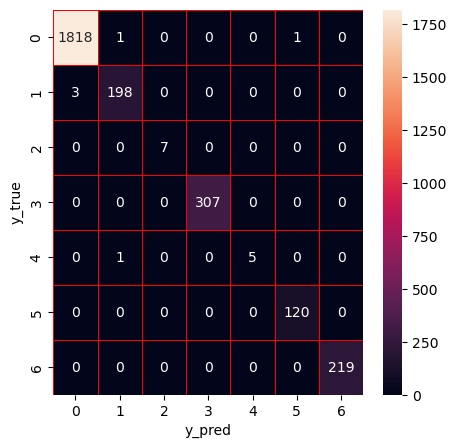

CPU times: user 1min 19s, sys: 3.66 s, total: 1min 22s
Wall time: 12.5 s


In [188]:
%%time
# Train the XGBoost algorithm
import xgboost as xgb
xg = xgb.XGBClassifier()

X_train_x = X_train.values
X_test_x = X_test.values

xg.fit(X_train_x, y_train)

y_pred = xg.predict(X_test_x)
print(classification_report(y_test,y_pred))
print("Accuracy of XGBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of XGBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of XGBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of XGBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of XGBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
xg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1820
           1       0.99      0.99      0.99       201
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00       307
           4       1.00      0.83      0.91         6
           5       0.99      0.99      0.99       120
           6       1.00      1.00      1.00       219

    accuracy                           1.00      2680
   macro avg       1.00      0.97      0.98      2680
weighted avg       1.00      1.00      1.00      2680

Accuracy of CatBoost: 0.9977611940298508
Precision of CatBoost: 0.9977618087486785
Recall of CatBoost: 0.9977611940298508
Average F1 of CatBoost: 0.9977444895817535
F1 of CatBoost for each type of attack: [0.99862675 0.99004975 1.         1.         0.90909091 0.99166667
 1.        ]


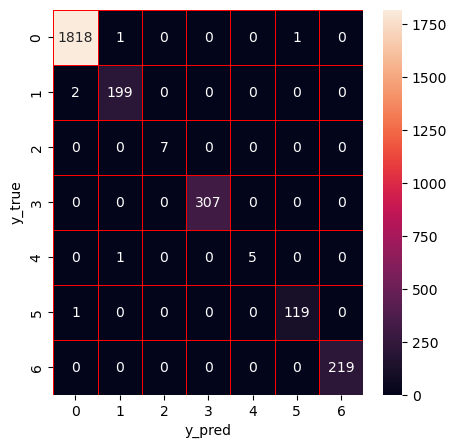

CPU times: user 2min 24s, sys: 6.3 s, total: 2min 30s
Wall time: 27.5 s


In [189]:
%%time
# Train the CatBoost algorithm
import catboost as cbt
cb = cbt.CatBoostClassifier(verbose=0,boosting_type='Plain')
#cb = cbt.CatBoostClassifier()

cb.fit(X_train, y_train)
y_pred = cb.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy of CatBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of CatBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of CatBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of CatBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of CatBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
cb_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

# added code for new modles 

### rf clasifaction

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1820
           1       0.98      0.98      0.98       201
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00       307
           4       1.00      0.83      0.91         6
           5       0.99      1.00      1.00       120
           6       1.00      0.99      0.99       219

    accuracy                           0.99      2680
   macro avg       0.99      0.97      0.98      2680
weighted avg       0.99      0.99      0.99      2680

Accuracy of Random forest: 0.9944029850746269
Precision of Random forest: 0.9944025591882302
Recall of Random forest: 0.9944029850746269
Average F1 of Random forest: 0.9943824230896448
F1 of Random forest for each type of attack: [0.99588251 0.98254364 1.         0.99674267 0.90909091 0.99585062
 0.99082569]


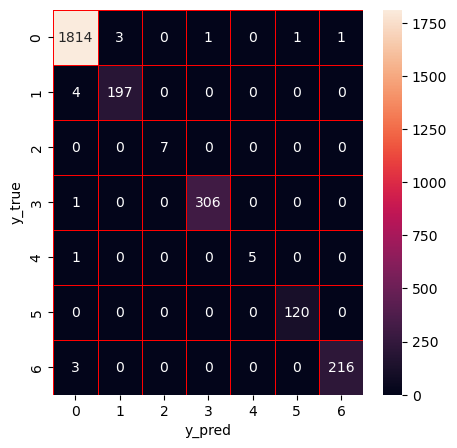

CPU times: user 5.76 s, sys: 36.4 ms, total: 5.8 s
Wall time: 5.81 s


In [190]:
%%time
# Train the random forest algorithm
from sklearn.ensemble import RandomForestClassifier
#rf = rft.CatBoostClassifier()
rf = RandomForestClassifier(n_estimators=200, max_depth=50)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy of Random forest: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of Random forest: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of Random forest: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of Random forest: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of Random forest for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
rf_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

### knn clasifaction

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1820
           1       0.93      0.99      0.96       201
           2       0.70      1.00      0.82         7
           3       0.97      1.00      0.99       307
           4       0.40      0.67      0.50         6
           5       0.93      0.98      0.96       120
           6       0.99      0.99      0.99       219

    accuracy                           0.98      2680
   macro avg       0.85      0.94      0.89      2680
weighted avg       0.98      0.98      0.98      2680

Accuracy of k-Neighbors: 0.9805970149253731
Precision of k-Neighbors: 0.9822941261430556
Recall of k-Neighbors: 0.9805970149253731
Average F1 of k-Neighbors: 0.9811455565708364
F1 of k-Neighbors for each type of attack: [0.98586083 0.95883777 0.82352941 0.98550725 0.5        0.95546559
 0.98861048]


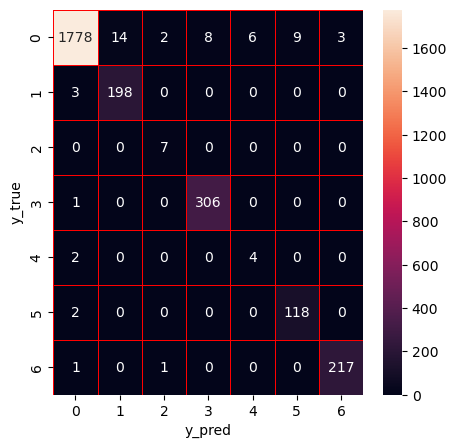

In [191]:
from sklearn.neighbors import KNeighborsClassifier
kn = KNeighborsClassifier(n_neighbors = 5,weights='distance')

kn.fit(X_train, y_train)
y_pred = kn.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy of k-Neighbors: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of k-Neighbors: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of k-Neighbors: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of k-Neighbors: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of k-Neighbors for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
kn_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

### addaptive boosting

              precision    recall  f1-score   support

           0       0.69      1.00      0.82      1820
           1       0.00      0.00      0.00       201
           2       0.00      0.00      0.00         7
           3       1.00      0.20      0.33       307
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00       120
           6       0.00      0.00      0.00       219

    accuracy                           0.70      2680
   macro avg       0.24      0.17      0.16      2680
weighted avg       0.59      0.70      0.59      2680

Accuracy of a-boost: 0.701865671641791
Precision of a-boost: 0.5864766944202242
Recall of a-boost: 0.701865671641791
Average F1 of a-boost: 0.5948452887903354
F1 of a-boost for each type of attack: [0.82000451 0.         0.         0.33152174 0.         0.
 0.        ]


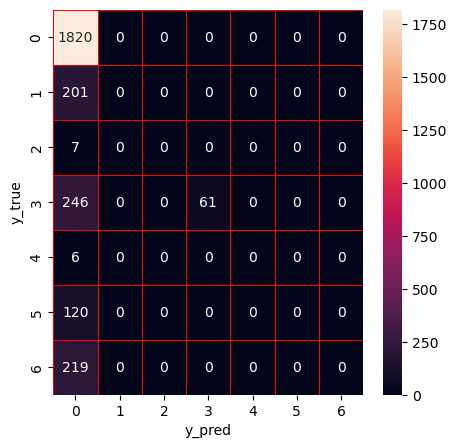

In [192]:
from sklearn.ensemble import AdaBoostClassifier #For Classification
from sklearn.ensemble import AdaBoostRegressor #For Regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

dtree = DecisionTreeClassifier()
dtree = RandomForestClassifier(n_estimators=200, max_depth=50)
ab = AdaBoostClassifier(n_estimators=100, base_estimator=dtree,learning_rate=1)


ab.fit(X_train, y_train)
y_pred = ab.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy of a-boost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of a-boost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of a-boost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of a-boost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of a-boost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
ab_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

### gradient boosting

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1820
           1       0.99      0.99      0.99       201
           2       1.00      1.00      1.00         7
           3       0.99      1.00      1.00       307
           4       1.00      0.67      0.80         6
           5       0.99      1.00      1.00       120
           6       1.00      1.00      1.00       219

    accuracy                           1.00      2680
   macro avg       1.00      0.95      0.97      2680
weighted avg       1.00      1.00      1.00      2680

Accuracy of g-boost: 0.996268656716418
Precision of g-boost: 0.996272839345757
Recall of g-boost: 0.996268656716418
Average F1 of g-boost: 0.9961936891895816
F1 of g-boost for each type of attack: [0.99725275 0.98753117 1.         0.99675325 0.8        0.99585062
 1.        ]


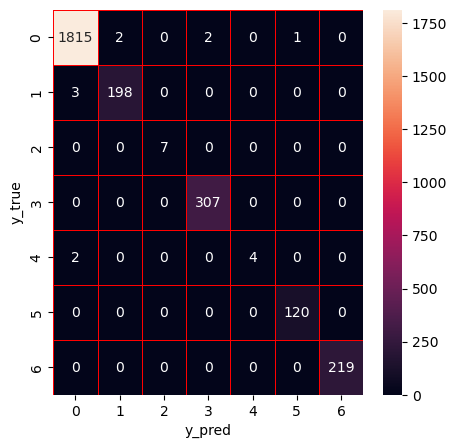

In [209]:
from sklearn.ensemble import GradientBoostingClassifier #For Classification

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy of g-boost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of g-boost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of g-boost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of g-boost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of g-boost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
gb_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

### bagging

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1820
           1       0.99      0.98      0.98       201
           2       1.00      1.00      1.00         7
           3       0.99      1.00      1.00       307
           4       1.00      0.67      0.80         6
           5       0.99      0.99      0.99       120
           6       1.00      1.00      1.00       219

    accuracy                           1.00      2680
   macro avg       1.00      0.95      0.97      2680
weighted avg       1.00      1.00      1.00      2680

Accuracy of baging: 0.9951492537313433
Precision of baging: 0.9951473400268459
Recall of baging: 0.9951492537313433
Average F1 of baging: 0.9950676734361394
F1 of baging for each type of attack: [0.99670511 0.98245614 1.         0.99675325 0.8        0.99166667
 0.9977221 ]


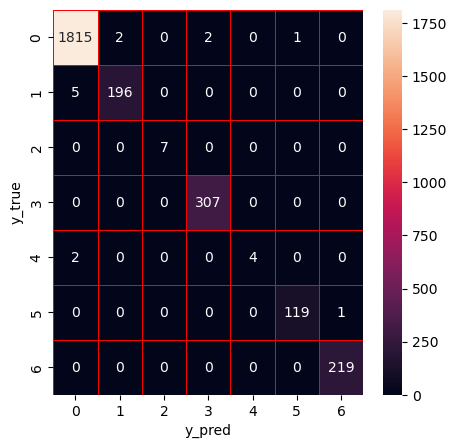

In [194]:
from sklearn.ensemble import BaggingClassifier

gb = GradientBoostingClassifier()# this was good will this improve it? dtree got .76
bg=BaggingClassifier(n_estimators=100, base_estimator=gb)
bg.fit(X_train, y_train)
y_pred = bg.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy of baging: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of baging: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of baging: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of baging: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of baging for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
bg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true") 
plt.show()

## Proposed ensemble model: Leader Class and Confidence Decision Ensemble (LCCDE)

LCCDE aims to achieve optimal model performance by identifying the best-performing base ML model with the highest prediction confidence for each class. 

### Find the best-performing (leading) model for each type of attack among the three ML models

In [195]:
# Leading model list for each class
'''
model=[]
for i in range(len(lg_f1)):
    if max(lg_f1[i],xg_f1[i],cb_f1[i]) == lg_f1[i]:
        model.append(lg)  
    elif max(lg_f1[i],xg_f1[i],cb_f1[i]) == xg_f1[i]:
        model.append(xg)
    else:
        model.append(cb)
'''
model = []
for i in range(len(lg_f1)):
    if max(lg_f1[i], xg_f1[i], cb_f1[i], rf_f1[i], kn_f1[i], ab_f1[i], gb_f1[i], bg_f1[i]) == lg_f1[i]:
        model.append(lg)
    elif max(lg_f1[i], xg_f1[i], cb_f1[i], rf_f1[i], kn_f1[i], ab_f1[i], gb_f1[i], bg_f1[i]) == xg_f1[i]:
        model.append(xg)
    elif max(lg_f1[i], xg_f1[i], cb_f1[i], rf_f1[i], kn_f1[i], ab_f1[i], gb_f1[i], bg_f1[i]) == cb_f1[i]:
        model.append(cb)
    elif max(lg_f1[i], xg_f1[i], cb_f1[i], rf_f1[i], kn_f1[i], ab_f1[i], gb_f1[i], bg_f1[i]) == rf_f1[i]:
        model.append(rf)
    elif max(lg_f1[i], xg_f1[i], cb_f1[i], rf_f1[i], kn_f1[i], ab_f1[i], gb_f1[i], bg_f1[i]) == kn_f1[i]:
        model.append(kn)
    elif max(lg_f1[i], xg_f1[i], cb_f1[i], rf_f1[i], kn_f1[i], ab_f1[i], gb_f1[i], bg_f1[i]) == ab_f1[i]:
        model.append(ab)
    elif max(lg_f1[i], xg_f1[i], cb_f1[i], rf_f1[i], kn_f1[i], ab_f1[i], gb_f1[i], bg_f1[i]) == gb_f1[i]:
        model.append(gb)
    else:
        model.append(bg)


In [200]:
import random

model=[]

for i in range(len(lg_f1)):
    max_f1 = max(lg_f1[i], xg_f1[i], cb_f1[i], rf_f1[i], kn_f1[i], ab_f1[i], gb_f1[i], bg_f1[i])
    models_with_max_f1 = []
    
    if lg_f1[i] == max_f1:
        models_with_max_f1.append(lg)
    if xg_f1[i] == max_f1:
        models_with_max_f1.append(xg)
    if cb_f1[i] == max_f1:
        models_with_max_f1.append(cb)
    if rf_f1[i] == max_f1:
        models_with_max_f1.append(rf)
    if kn_f1[i] == max_f1:
        models_with_max_f1.append(kn)
    if ab_f1[i] == max_f1:
        models_with_max_f1.append(ab)
    if gb_f1[i] == max_f1:
        models_with_max_f1.append(gb)
    if bg_f1[i] == max_f1:
        models_with_max_f1.append(bg)
        
    if len(models_with_max_f1) == 1:
        model.append(models_with_max_f1[0])
    else:
        model.append(random.choice(models_with_max_f1))


In [201]:
model

[LGBMClassifier(),
 GradientBoostingClassifier(),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               objective='multi:softprob', predictor=None, ...),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_

**Leading Model for Each Type of Attack:**  
0 BENIGN: &emsp; XGBClassifier  
1 Bot:        &emsp;  &emsp;      XGBClassifier   
2 BruteForce:  &emsp;      LGBMClassifier  
3 DoS:        &emsp;   &emsp;   XGBClassifier  
4 Infiltration:  &emsp;       LGBMClassifier  
5 PortScan:  &emsp;       LGBMClassifier  
6 WebAttack:    &emsp;      XGBClassifier  

## LCCDE Prediction

In [197]:
def LCCDE(X_test, y_test, m1, m2, m3):
    i = 0
    t = []
    m = []
    yt = []
    yp = []
    l = []
    pred_l = []
    pro_l = []

    # For each class (normal or a type of attack), find the leader model
    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        y_pred1 = m1.predict(xi2.reshape(1, -1))      # model 1 (LightGBM) makes a prediction on text sample xi
        y_pred1 = int(y_pred1[0])
        y_pred2 = m2.predict(xi2.reshape(1, -1))      # model 2 (XGBoost) makes a prediction on text sample xi
        y_pred2 = int(y_pred2[0])
        y_pred3 = m3.predict(xi2.reshape(1, -1))      # model 3 (Catboost) makes a prediction on text sample xi
        y_pred3 = int(y_pred3[0])

        p1 = m1.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 1 
        p2 = m2.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 2  
        p3 = m3.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 3  

        # Find the highest prediction probability among all classes for each ML model
        y_pred_p1 = np.max(p1)
        y_pred_p2 = np.max(p2)
        y_pred_p3 = np.max(p3)

        if y_pred1 == y_pred2 == y_pred3: # If the predicted classes of all the three models are the same
            y_pred = y_pred1 # Use this predicted class as the final predicted class

        elif y_pred1 != y_pred2 != y_pred3: # If the predicted classes of all the three models are different
            # For each prediction model, check if the predicted class’s original ML model is the same as its leader model
            if model[y_pred1]==m1: # If they are the same and the leading model is model 1 (LightGBM)
                l.append(m1)
                pred_l.append(y_pred1) # Save the predicted class
                pro_l.append(y_pred_p1) # Save the confidence

            if model[y_pred2]==m2: # If they are the same and the leading model is model 2 (XGBoost)
                l.append(m2)
                pred_l.append(y_pred2)
                pro_l.append(y_pred_p2)

            if model[y_pred3]==m3: # If they are the same and the leading model is model 3 (CatBoost)
                l.append(m3)
                pred_l.append(y_pred3)
                pro_l.append(y_pred_p3)

            if len(l)==0: # Avoid empty probability list
                pro_l=[y_pred_p1,y_pred_p2,y_pred_p3]

            elif len(l)==1: # If only one pair of the original model and the leader model for each predicted class is the same
                y_pred=pred_l[0] # Use the predicted class of the leader model as the final prediction class

            else: # If no pair or multiple pairs of the original prediction model and the leader model for each predicted class are the same
                max_p = max(pro_l) # Find the highest confidence
                
                # Use the predicted class with the highest confidence as the final prediction class
                if max_p == y_pred_p1:
                    y_pred = y_pred1
                elif max_p == y_pred_p2:
                    y_pred = y_pred2
                else:
                    y_pred = y_pred3  
        
        else: # If two predicted classes are the same and the other one is different
            n = mode([y_pred1,y_pred2,y_pred3]) # Find the predicted class with the majority vote
            y_pred = model[n].predict(xi2.reshape(1, -1)) # Use the predicted class of the leader model as the final prediction class
            y_pred = int(y_pred[0]) 

        yt.append(yi)
        yp.append(y_pred) # Save the predicted classes for all tested samples
    return yt, yp

In [203]:
from statistics import mode
import numpy as np
#import streamlit as st

def LCCDE(X_test, y_test, models):
    i = 0
    t = []
    m = []
    yt = []
    yp = []
    l = []
    pred_l = []
    pro_l = []

    # For each class (normal or a type of attack), find the leader model
    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2 = np.array(list(xi.values()))

        y_preds = []
        y_probs = []

        # Make predictions and probabilities using all the input models
        for model in models:
            y_pred = model.predict(xi2.reshape(1, -1))
            y_preds.append(int(y_pred[0]))

            y_prob = model.predict_proba(xi2.reshape(1, -1))
            y_probs.append(np.max(y_prob))

        if all(y == y_preds[0] for y in y_preds):
            y_pred = y_preds[0]

        elif len(set(y_preds)) == len(y_preds):
            for j, y in enumerate(y_preds):
                if models[y] == models[mode(y_preds)]:
                    l.append(models[y])
                    pred_l.append(y)
                    pro_l.append(y_probs[j])
            
            if len(l) == 0:
                pro_l = y_probs
            
            elif len(l) == 1:
                y_pred = pred_l[0]

            else:
                max_p = max(pro_l)
                y_pred = pred_l[pro_l.index(max_p)]

        else:
            n = mode(y_preds)
            y_pred = models[n].predict(xi2.reshape(1, -1))
            y_pred = int(y_pred[0])

        yt.append(yi)
        yp.append(y_pred)

    return yt, yp


In [210]:
%%time
# Implementing LCCDE
#yt, yp = LCCDE(X_test, y_test, m1 = lg, m2 = xg, m3 = cb)
# note to self gb is not in this it was not working 
models = [lg,xg,cb,rf,kn,ab,gb,bg]
yt, yp = LCCDE(X_test, y_test, models)

CPU times: user 1h 56min 3s, sys: 16min 16s, total: 2h 12min 19s
Wall time: 1h 18min 44s


In [211]:
# The performance of the proposed lCCDE model
print("Accuracy of LCCDE: "+ str(accuracy_score(yt, yp)))
print("Precision of LCCDE: "+ str(precision_score(yt, yp, average='weighted')))
print("Recall of LCCDE: "+ str(recall_score(yt, yp, average='weighted')))
print("Average F1 of LCCDE: "+ str(f1_score(yt, yp, average='weighted')))
print("F1 of LCCDE for each type of attack: "+ str(f1_score(yt, yp, average=None)))

Accuracy of LCCDE: 0.9522388059701492
Precision of LCCDE: 0.9104153063811157
Recall of LCCDE: 0.9522388059701492
Average F1 of LCCDE: 0.9305502943694537
F1 of LCCDE for each type of attack: [0.96625033 0.98507463 1.         0.99836868 0.8        0.
 1.        ]


In [212]:
# Comparison: The F1-scores for each base model
print("F1 of LightGBM for each type of attack: "+ str(lg_f1))
print("F1 of XGBoost for each type of attack: "+ str(xg_f1))
print("F1 of CatBoost for each type of attack: "+ str(cb_f1))

F1 of LightGBM for each type of attack: [0.99862675 0.98753117 1.         1.         0.90909091 0.99585062
 1.        ]
F1 of XGBoost for each type of attack: [0.99862675 0.98753117 1.         1.         0.90909091 0.99585062
 1.        ]
F1 of CatBoost for each type of attack: [0.99862675 0.99004975 1.         1.         0.90909091 0.99166667
 1.        ]


**Conclusion**: The performance (F1-score) of the proposed LCCDE ensemble model on each type of attack detection is higher than any base ML model.